# Cats vs Dog Replication, Version 1

Dataset is from the Cats v.s. Dogs Redux Kaggle competition. Data downloaded by executing `kaggle competitions download -c dogs-vs-cats-redux-kernels-edition` using the official Kaggle CLI.

How to organize training data so that all cat and dog pictures are in their individual folders within the `train` folder:

```
mkdir dog
mkdir cat
mv dog*jpg dog
mv cat*jpg cat
```


In [3]:
import sys; sys.path.append('../fastai')

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/data/dogs-vs-cats-redux-kernels-edition/"

# model parameters
sz=224
arch = resnet34

In [7]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


### First quick model
Here is a very basic convolutional neural network model trained for 3 epochs without any application of the other techniques to improve performance.

#### To Do:
* Submit the output of this model to Kaggle as a baseline

In [8]:
tfms = tfms_from_model(arch,sz)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.047767   0.026469   0.989746  
    1      0.037128   0.025358   0.98877   
    2      0.041706   0.025352   0.989258  



[0.025352146, 0.9892578125]

### End-to-End Workflow for Training a World Class Model

#### 1. Enable data augmentation and precompute=True
Depending on the images we are working with, set `aug_tfms` to either transforms_side_on or transform_top_down (for satellite images). For ImageNet like images, we use transforms_side_on.

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

#### 2. Find learning rate to be used to train dense layer of model

First, find a learning rate using the learning rate finder method. To do this, we must define a new, untrained, mode. We are finding the learning rate only from the unfrozen dense layer (the last layer in the convolutional neural net) that we want to customize for our image data. The Python methods used here are:
    * lr_find()
    * plot_lr() (from sched)
    * plot() (also from sched 

In [14]:
find_lr_learner = ConvLearner.pretrained(arch, data, precompute=True)
lrf = find_lr_learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 296/360 [00:04<00:00, 70.34it/s, loss=0.41] 


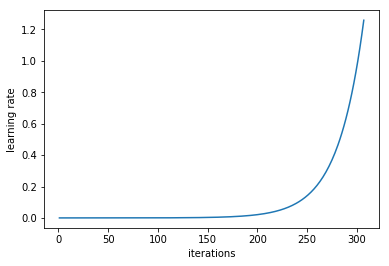

In [15]:
find_lr_learner.sched.plot_lr()

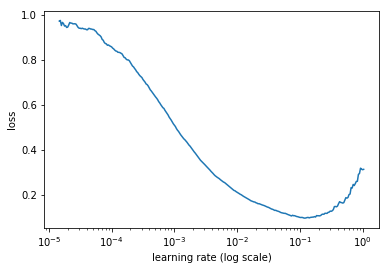

In [16]:
find_lr_learner.sched.plot()

Based on the analysis of the loss function against various learning rates, the optimal learning rate is the value just before the learning where loss is at the minimum. We can pick 1e-2.

#### 3. Train last layer from precomputed activations for 1 to 2 epochs
We will use the learning rate we found above to train the last layer of the model. We initialize a new model by using the ConvLearner class (and bind it to the learn variable) and pass the architecture and data we have defined and initialized for it. We will not use the model we used to find our learning rate.

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [17]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.039411   0.027764   0.991211  
    1      0.0385     0.025287   0.990723  



[0.025286883, 0.99072265625]

#### 4. Train last layer with data augmentation with cycle_len=1 

Here we train just the last layer. The reason we do this first before training the entire network in step 5 is because the final layer only have random values for paramters. We wouldn't want to train the entire network first while having an untrained final layer.

__Questions !!!__

1. What is cycle_len=1? Why do we use it?
2. Why not do this step at step 3? why do we first do an initial training with non-augmented data?
3. Why not just jump straight to unfreezing the entire model and training it using differential learning rates (i.e. jump straight to step 5)?

Note that you don't need to run this again because you can load the model that you trained earlier. Use `learn.load(MODELNAME)`.

In [1]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

# Save model so we don't have to train it from scratch next time
learn.save('224_lastlayer_catsVDog_replication_V1')
learn.load('224_lastlayer_catsVDog_replication_V1')

NameError: name 'learn' is not defined

#### 5. Unfreeze all layers
Unfreeze early, middle and later layers. We are at this point going to train all the layers starting from their pretrained parameter values.

In [23]:
learn.unfreeze()

#### 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
In training all the layers, we only want to only want maximum customization of the parameters of the later layers. For the early layers, these have been trained to detect very general attributes that is also applicable to our dataset. Thus, we don't want to train these early layers too much and so we set the learning rate for these early layer to be 10 times smaller than the last layer.

In [24]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save('224_trainedAll_catsVDog_replication_V1')
learn.load('224_trainedAll_catsVDog_replication_V1')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.051889   0.02381    0.990723  
    1      0.037085   0.01966    0.992676  
    2      0.031327   0.018767   0.993652  
    3      0.030479   0.02077    0.992188  
    4      0.027538   0.018497   0.993652  
    5      0.019366   0.018417   0.993652  
    6      0.019606   0.018017   0.993652  



[0.018016517, 0.99365234375]

#### 7. Use learning rate finder again
What is the point of doing this? Why do we need a new learning rate again?

#### 8. Train full network with cycle_mult=2 until overfitting


### Loading Previously Trained Model
To load model starting from step 6 (and avoid having to retrain the entire network), run the following code

In [13]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('224_trainedAll_catsVDog_replication_V1')

### Create Kaggle Submission
1. Remove validation set and train on entire dataset
2. 

In [18]:
import os
os.listdir(PATH)

['models', 'train', 'sample', 'tmp', 'valid', 'test1']